# Exercício 07 - Tarefa Final

Aluno: Frederico Luis de Azevedo

Professor: Dr. Francisco de Assis Boldt

## Introdução

Neste exercício será implementado um algoritmo de Rede Neural backpropagation capaz de resolver um problema binário e uma Rede Neural em encapsulada em Keras capaz de resolver o mesmo problema. Essas duas redes serão comparadas com o MLPClassifier da biblioteca scikit-learn

## Bibliotecas e Inicialização

In [15]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, ClassifierMixin
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_gaussian_quantiles, make_blobs
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras.utils import to_categorical

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore")

np.random.seed(42)

## Base de dados

Para este exercício serão construídas quatro bases de dados binárias com diferentes quantidades características e amostras. As duas primeiras bases terão os dados linarmente separáveis e as outras duas não.

- Base 1: Linearmente separável com 10 características e 100 amostras
- Base 2: Linearmente separável com 50 características e 500 amostras
- Base 3: Não separável com 10 características e 100 amostras
- Base 4: Não separável com 50 características e 500 amostras

In [2]:
datasets = [make_blobs(n_samples=100, centers=2, n_features=10, center_box=(0, 10), random_state=30),
            make_blobs(n_samples=500, centers=2, n_features=50, center_box=(0, 10), random_state=40),
            make_classification(n_samples=100, n_features=10, n_clusters_per_class=1, random_state=42),
            make_gaussian_quantiles(n_samples = 500, n_features = 50, n_classes = 2, random_state=42)]

## Implementação da Rede Neural Customizada (com Backpropagation)

In [3]:
class NeuralNetwork(BaseEstimator, ClassifierMixin):
    
    def __init__ (self, epochs = 10000, learning_rate = 0.2): 
        
        self.epochs = epochs
        self.learning_rate = learning_rate
        
        self.w1 = []
        self.w2 = []
        
    def fit(self, X, y):
        
        # Inicializa os pesos aleatoriamente
        self.w1 = 2 * np.random.rand(3, 3) - 1
        self.w2 = 2 * np.random.rand(3, 1) - 1
        
        for epoch in range(self.epochs):
            
            for i in range(X.shape[0]):
                
                # Antes de iniciar, adiciona o bias
                a = self._add_bias(X[i])
            
                z1 = self._forward(a, self.w1)
                z2 = self._forward(z1, self.w2)
                
                pred = z2
                real = y[i]

                # delta do erro
                delta_error = self._delta_error(real, pred)
                    
                d1 = self._backward(delta_error, z1, z2, self.w2)
                d2 = self._backward(d1, a, z1, self.w1)
                
                
    def predict(self, X):
        
        result = []
        
        for x in X:
            
            # Antes de iniciar, adiciona o bias
            a = self._add_bias(x)
            
            z1 = self._forward(a, self.w1)
            z2 = self._forward(z1, self.w2)
            
            result.append(z2)
        
        return np.array(result)

    def _forward(self, x, w):
        r = np.dot(x, w)
        z = self._sigmoid(r)
        return z
    
    def _backward(self, delta_error, x, y, w):
        
        w_transpose = np.transpose(w)
        
        dy = self._sigmoid_der(y)
        
        delta_error_y = np.multiply(delta_error, dy)
        
        d = np.dot(delta_error_y, w_transpose)
        
        d2 = np.dot(x.reshape(len(x), 1), delta_error_y.reshape(1, len(delta_error_y)))

        w -= self.learning_rate * d2

        return d
    
    def _add_bias(self, x):
        return np.concatenate((np.ones(1).T, np.array(x)))
        
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def _sigmoid_der(self, z):
        return np.multiply(z, (1 - z))
    
    def _delta_error(self, y, y_pred):
        r = y_pred - y
        return r

## Implementação da Rede Neural em Keras
A Rede Neural em Keras terá 3 camadas além da camada de entrada: duas camadas intermediárias e uma de saída. A rede abaixo foi criada para demonstração da arquitetura do modelo. A rede utilizada na análise das bases no próximo tópico será montada em tempo real para cada execução individual de modo não haver reutilização de redes já treinadas anteriormente.

In [4]:
model = Sequential()
model.add(Dense(12, input_dim=2, activation='sigmoid'))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

In [5]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                36        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 149
Trainable params: 149
Non-trainable params: 0
_________________________________________________________________
None


## Plotando o Meshgrid da Separação de cada Rede Neural

In [6]:
names = ["CustomANN", "MLPClassifier", "KerasANN"]
classifiers = [NeuralNetwork(), MLPClassifier(activation='logistic'), Sequential()]

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



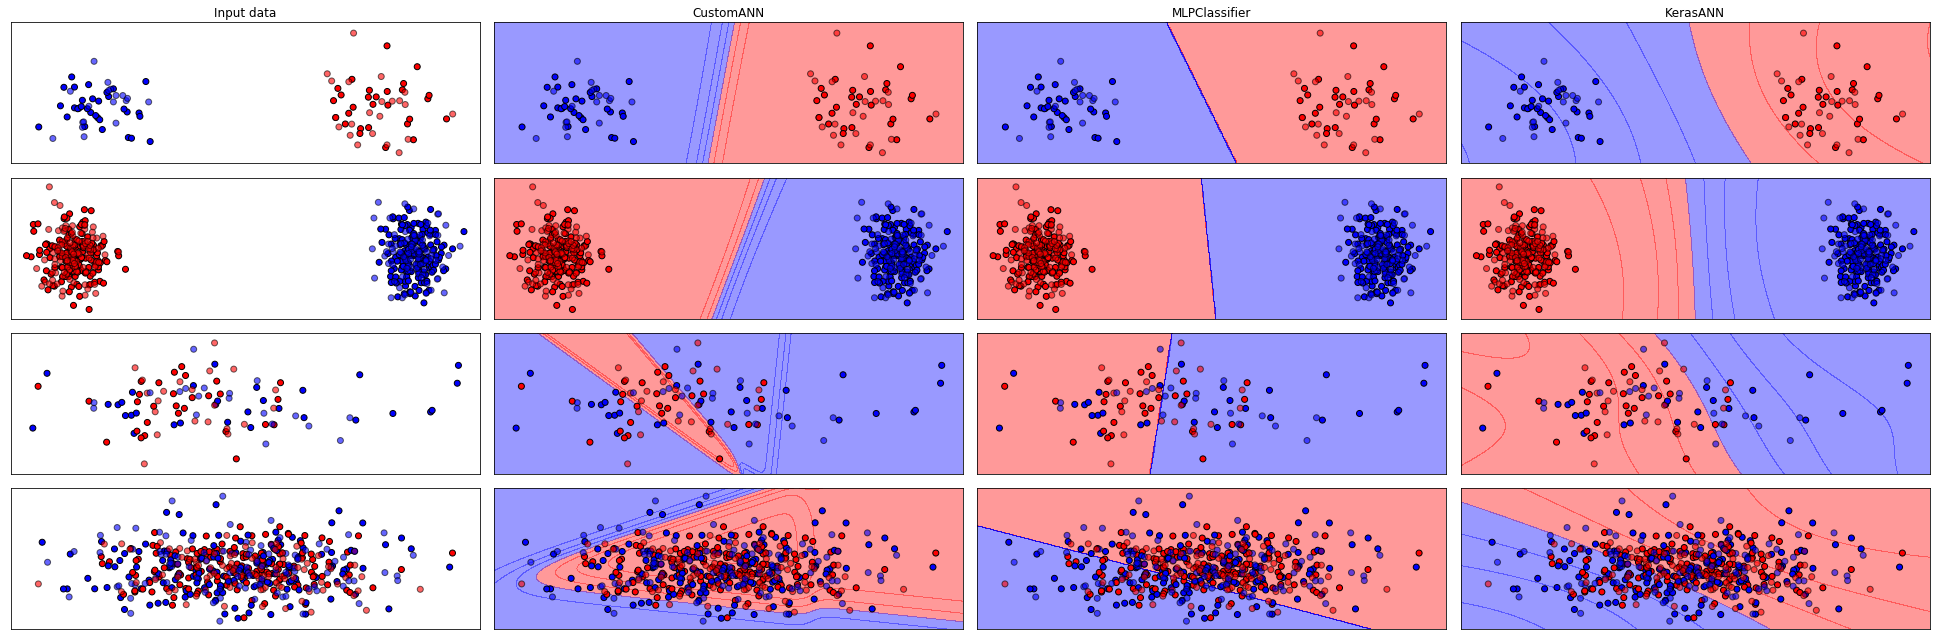

In [7]:
h = .02  # step size in the mesh


figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    
    
    #--- PCA --- Obtendo as duas características mais representativas
    X = PCA(n_components=2).fit_transform(X)
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        
        if (type(clf).__name__ == 'Sequential'):
            clf = Sequential()
            clf.add(Dense(12, input_dim=2, activation='sigmoid'))
            clf.add(Dense(8, activation='sigmoid'))
            clf.add(Dense(1, activation='sigmoid'))
            clf.compile(metrics=['accuracy'], loss='binary_crossentropy',  optimizer='adam')
            clf.fit(X_train, y_train, epochs=100,batch_size=128, shuffle=True, verbose=0)
        else:
            clf.fit(X_train, y_train)
            
        resolution=0.02
        # setup marker generator and color map
        markers = ('s', 'x', 'o', '^', 'v')
        colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
        cmap = ListedColormap(colors[:len(np.unique(y))])

        # plot the decision surface
        x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                               np.arange(x2_min, x2_max, resolution))
        Z = clf.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
        Z = Z.reshape(xx1.shape)
        ax.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
        #ax.xlim(xx1.min(), xx1.max())
        #ax.ylim(xx2.min(), xx2.max())

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        i += 1

plt.tight_layout()
plt.show()

## Resultados

É possível observar que as três redes neurais performam muito bem com bases linearmente separáveis, independente da quantidade de características e amostras. Todas as 3 conseguiram definir um limiar de separação perfeito das duas classes. Em bases que não são linearmente separáveis, a rede ANN customizada foi a única que conseguiu gerar um limiar de classificação menos linear do que o MLPClassifier e a rede Keras, que tiveram resultados visuais praticamente semelhantes dando 